In [9]:
import sys
import os

is_kaggle = "KAGGLE_KERNEL_RUN_TYPE" in os.environ

if is_kaggle:
    repo_path = "/kaggle/working/cmi_competition"
    
    if not os.path.exists(repo_path):
        os.system("git clone https://github.com/zeyad-shaban/cmi_competition.git " + repo_path)
    else:
        os.system(f"cd {repo_path} && git pull && cd ..")

    
    sys.path.append(repo_path)
    raw_path = "/kaggle/input/cmi-detect-behavior-with-sensor-data"
    encoder_path = os.path.join(repo_path, "models", "label_encoder.pkl")
else:
    raw_path = "../data/raw"
    encoder_path = "../models/label_encoder.pkl"
    sys.path.insert(0, os.path.abspath('..'))

In [10]:
%load_ext autoreload
%autoreload 2

from src.feature_engineer import load_encoder, rotation_feature_engineer, accelrometer_feature_engineer
from src.data_cleaning import clean_df, normalize_sequence_count
from src.utils.model_utils import evaulate_model, train_model, predict_in_chunks
from src.utils.visualize_utils import plot_cm, get_avg_fold
from src.utils.math_utils import create_spectrograms_torch
import lightgbm as lgb

import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5", "tof_5_v20"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_3_v17,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,57.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,68.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,97.0,107.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,151.0,113.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,207.0,121.0,192.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,219.0,93.0,46.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,216.0,82.0,50.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,208.0,83.0,53.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,210.0,91.0,48.0,1,30,0,1,186.0,55,30.0


In [12]:
cleaned_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False) #, min_gesture_count=-1)
cleaned_df = normalize_sequence_count(cleaned_df)

cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer (cleaned_df)

cleaned_df

[rot_na] Remaining: 254179/574945 (-320766, 55.8% dropped)
[gesture_len outliers] Remaining: 222934/254179 (-31245, 12.3% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,rotvec_x_diff,rotvec_z_diff,angular_mag,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.000000,0.000000,0.000000,29171.0,19688.0,11033.0,9.924192,0.000000,0.000000,0.000000
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,-0.003831,-0.028692,0.030410,25.0,61.0,192.0,10.113299,-0.042969,0.117188,0.343750
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.032691,0.025619,0.041628,76.0,24.0,66.0,10.536305,0.042969,-0.152344,0.957031
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,0.050705,0.046642,0.092412,21.0,0.0,86.0,9.782531,-0.539062,0.343750,-1.187500
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,0.014674,0.006900,0.024087,0.0,0.0,1.0,9.925453,0.500000,0.191406,-0.765625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252765,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,-0.010090,-0.038689,0.041088,4.0,6.0,18.0,9.919849,0.882812,-0.578125,-1.683594
252766,SEQ_065531_000052,Non-Target,SEQ_065531,52,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.013186,0.007692,0.020022,3.0,0.0,2.0,10.574324,0.304688,-0.574219,-0.542969
252767,SEQ_065531_000052,Non-Target,SEQ_065531,53,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,31.0,4.0,19.0,10.574324,0.000000,0.000000,0.000000
252768,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.000000,0.0,0.0,10.0,10.574324,0.000000,0.000000,0.000000


In [13]:
feautures_of_interest = [
    "acc_x",
    "acc_y",
    "acc_z",
    "fft_acc_x",
    "fft_acc_y",
    "fft_acc_z",
    "acc_mag",
    "jerk_acc_x",
    "jerk_acc_y",
    "jerk_acc_z",
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_mag",
    # "tof_1_v20",
    # "thm_2",
    # "thm_4",
    # "thm_5",
]

agg_recipe = {
    "gesture": ["first"],
    "subject": ["first"],
    
    # ---Rotation
    "rotvec_x": ["mean", "std"],
    "rotvec_y": ["mean", "std"],
    "rotvec_z": ["mean", "std"],
    "rot_angle": ["mean", "std"],
    # angular velocity
    "rotvec_x_diff": ["mean", "std", "min", "max"],
    "rotvec_y_diff": ["mean", "std", "min", "max"],
    "rotvec_z_diff": ["mean", "std", "min", "max"],
    "angular_mag": ["mean", "std", "max"],
    
    # ---Accelrometer
    "acc_x": ["mean", "std"],
    "acc_y": ["mean", "std"],
    "acc_z": ["mean", "std"],
    # mag
    "acc_mag": ["mean", "std"],
    # jerk
    "jerk_acc_x": ["mean", "std", "min", "max"],
    "jerk_acc_y": ["mean", "std", "min", "max"],
    "jerk_acc_z": ["mean", "std", "min", "max"],
    # fft stuff
    "fft_acc_x": ["mean", "std"],
    "fft_acc_y": ["mean", "std"],
    "fft_acc_z": ["mean", "std"],
    
    #
    # "thm_2": ["mean", "std"],
    # "thm_4": ["mean", "std"],
    # "thm_5": ["mean", "std"],
    # "thm_5": ["mean", "std"],
    # "tof_1_v20": ["mean", "std"],
}

sequence_groups = cleaned_df.groupby('sequence_id')
encoder = load_encoder(encoder_path) # type: ignore


# full time lenght features
features_full_seq = np.array([group for _, group in sequence_groups[feautures_of_interest]], dtype=np.float32) # N x n_timesteps x n_features
features_full_seq = torch.tensor(features_full_seq.transpose(0, 2, 1).copy() )# N x n_features x n_timestpes

filtered_df = sequence_groups[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
features_summaries = torch.tensor(filtered_df.drop(columns=["gesture_first", "subject_first"]).to_numpy(), dtype=torch.float32).contiguous().numpy()

target_df = filtered_df['gesture_first']
target_np = encoder.transform(target_df).astype(np.int64) # type: ignore
target_tensor = torch.tensor(target_np)

target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

features_full_seq.shape, target_tensor.shape

(torch.Size([7222, 15, 35]), torch.Size([7222]))

In [14]:
spectograms = create_spectrograms_torch(features_full_seq)
spectograms.shape

torch.Size([7222, 15, 9, 9])

In [22]:
class SimpleModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=5, stride=1, padding="same", bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Dropout(0.1),
            #
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding="same", bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Dropout(0.1),
            #
        )

        self.adaptive_layer = nn.Sequential(nn.AdaptiveAvgPool2d(1),)
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes),
        )

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        x = self.conv_layer(x)  # x out_dim
        x = self.adaptive_layer(x)
        y_pred = self.fc(x)

        return y_pred


dummy_input = torch.rand(64, 15, 224, 224)
dummy_model = SimpleModel(15, len(encoder.classes_))
dummy_model(dummy_input).shape

nn.Sequential(*list(dummy_model.children())[:-1])(dummy_input).shape

torch.Size([64, 32, 1, 1])

In [ ]:
# FacePlant? aka what the fuck am i doing with my life
n_splits = 4
gkf = GroupKFold(n_splits)
subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])

n_features = features_full_seq.shape[1]
batch_size = 33
n_epochs = 100

X_test_arr = []
X_train_arr = []
y_train_arr = []
y_test_arr = []

test_subjects = []
lgbm_folds_score = []
cnn_folds_score = []
importances = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=spectograms, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    # ---Prepare
    print(f"\n------FOLD {fold + 1}/{n_splits}------\n")
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = spectograms[train_indices], target_tensor[train_indices] # B x F x T
    X_test, y_test = spectograms[test_indices], target_tensor[test_indices]
    
    mean = X_train.mean(dim=(0, 2, 3)).view(1, -1, 1, 1)   # shape (1xFx1)
    std  = X_train.std(dim=(0, 2, 3), unbiased=False).view(1, -1, 1, 1) + 1e-8  # shape (1xFx1)

    # Normalize
    X_train = (X_train - mean) / (std + 1e-14)
    X_test  = (X_test  - mean) / (std + 1e-14)
    
    X_train_arr.append(X_train.cpu().numpy())
    X_test_arr.append(X_test.cpu().numpy())
    y_train_arr.append(y_train.cpu().numpy())
    y_test_arr.append(y_test.cpu().numpy())
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    # ---End prepare
    
    model = SimpleModel(n_features, len(encoder.classes_)).to(device)
    model.train()
    train_model(model, dataloader_train, n_epochs, True, spectogram_features=True)
    
    model.eval()
    y_pred = predict_in_chunks(model, X_test, device, batch_size=10)
    score_dashboard = evaulate_model(y_pred, y_test, target_gestures_encoded, encoder)
    cnn_folds_score.append(score_dashboard)
    
    # Train GBM on CNN features
    model_cut_head = nn.Sequential(*list(dummy_model.children())[:-1])
    model_cut_head.eval()
    
    cnn_features_train = model_cut_head(X_train).view(X_train.shape[0], -1).detach().cpu().numpy() # B x cnn_out_features
    cnn_features_test = model_cut_head(X_test).view(X_test.shape[0], -1).detach().cpu().numpy() # B x cnn_out_features
    
    lgbm_features_train = np.concat([features_summaries[train_indices], cnn_features_train], axis=1)
    lgbm_features_test = np.concat([features_summaries[test_indices], cnn_features_test], axis=1)
    
    lgbm = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31)
    lgbm.fit(lgbm_features_train, y_train)
    importances.append(lgbm.feature_importances_)

    y_pred = lgbm.predict(lgbm_features_test)
    score_dashboard = evaulate_model(y_pred, y_test, target_gestures_encoded, encoder)
    lgbm_folds_score.append(score_dashboard)


------FOLD 1/4------



LGBM FOLD SCORE
macro: 0.491, binary: 0.946, competition: 0.718


,precision,recall,f1-score,support
Above ear - pull hair,0.482918,0.431150,0.453515,146.250000
Cheek - pinch skin,0.362204,0.340067,0.350740,150.000000
Eyebrow - pull hair,0.337410,0.314662,0.323742,153.250000
Eyelash - pull hair,0.498875,0.485766,0.490166,149.750000
Forehead - pull hairline,0.501404,0.502937,0.501894,147.250000
Forehead - scratch,0.614537,0.613660,0.612105,150.000000
Neck - pinch skin,0.351583,0.338818,0.344411,147.750000
Neck - scratch,0.450603,0.437028,0.441336,145.500000
Write name on leg,0.871455,0.932679,0.900987,615.750000
accuracy,0.602947,0.602947,0.602947,0.602947


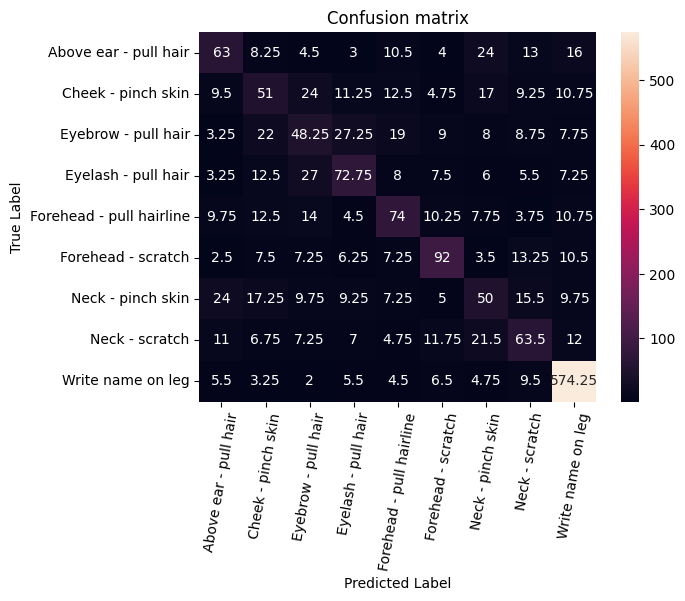

In [ ]:
print("LGBM FOLD SCORE")
fold_scores = lgbm_folds_score
fold = get_avg_fold(fold_scores)

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

CNN FOLD SCORE
macro: 0.449, binary: 0.941, competition: 0.695


,precision,recall,f1-score,support
Above ear - pull hair,0.499582,0.369349,0.423077,146.250000
Cheek - pinch skin,0.318651,0.298885,0.306477,150.000000
Eyebrow - pull hair,0.307317,0.230061,0.261736,153.250000
Eyelash - pull hair,0.361059,0.513441,0.422629,149.750000
Forehead - pull hairline,0.456898,0.448147,0.452108,147.250000
Forehead - scratch,0.546687,0.637973,0.588099,150.000000
Neck - pinch skin,0.311975,0.271040,0.288471,147.750000
Neck - scratch,0.440305,0.410593,0.411671,145.500000
Write name on leg,0.877637,0.901059,0.889122,615.750000
accuracy,0.568941,0.568941,0.568941,0.568941


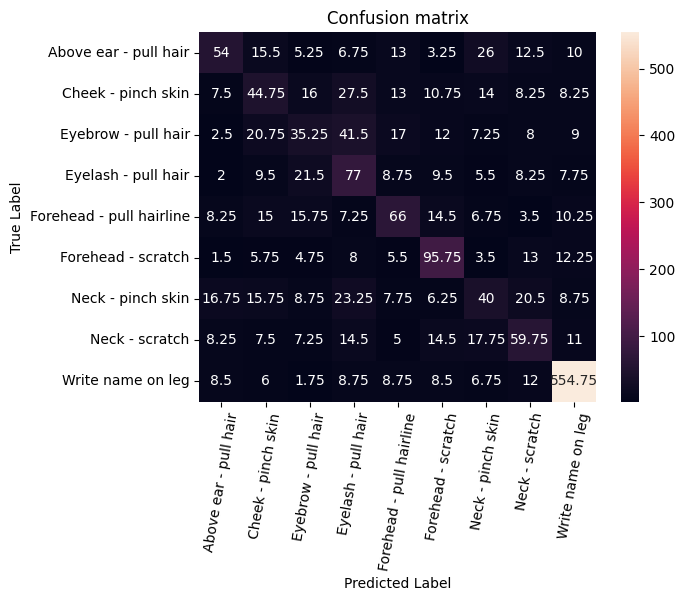

In [ ]:
print("CNN FOLD SCORE")
fold_scores = cnn_folds_score
fold = get_avg_fold(fold_scores)

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

['rotvec_x_mean', 'rotvec_x_std', 'rotvec_y_mean', 'rotvec_y_std', 'rotvec_z_mean', 'rotvec_z_std', 'rot_angle_mean', 'rot_angle_std', 'rotvec_x_diff_mean', 'rotvec_x_diff_std', 'rotvec_x_diff_min', 'rotvec_x_diff_max', 'rotvec_y_diff_mean', 'rotvec_y_diff_std', 'rotvec_y_diff_min', 'rotvec_y_diff_max', 'rotvec_z_diff_mean', 'rotvec_z_diff_std', 'rotvec_z_diff_min', 'rotvec_z_diff_max', 'angular_mag_mean', 'angular_mag_std', 'angular_mag_max', 'acc_x_mean', 'acc_x_std', 'acc_y_mean', 'acc_y_std', 'acc_z_mean', 'acc_z_std', 'acc_mag_mean', 'acc_mag_std', 'jerk_acc_x_mean', 'jerk_acc_x_std', 'jerk_acc_x_min', 'jerk_acc_x_max', 'jerk_acc_y_mean', 'jerk_acc_y_std', 'jerk_acc_y_min', 'jerk_acc_y_max', 'jerk_acc_z_mean', 'jerk_acc_z_std', 'jerk_acc_z_min', 'jerk_acc_z_max', 'fft_acc_x_mean', 'fft_acc_x_std', 'fft_acc_y_mean', 'fft_acc_y_std', 'fft_acc_z_mean', 'fft_acc_z_std', 'cnn_0', 'cnn_1', 'cnn_2', 'cnn_3', 'cnn_4', 'cnn_5', 'cnn_6', 'cnn_7', 'cnn_8', 'cnn_9', 'cnn_10', 'cnn_11', 'cnn_1

,feature,importance
20,angular_mag_mean,546.75
22,angular_mag_max,401.00
21,angular_mag_std,301.00


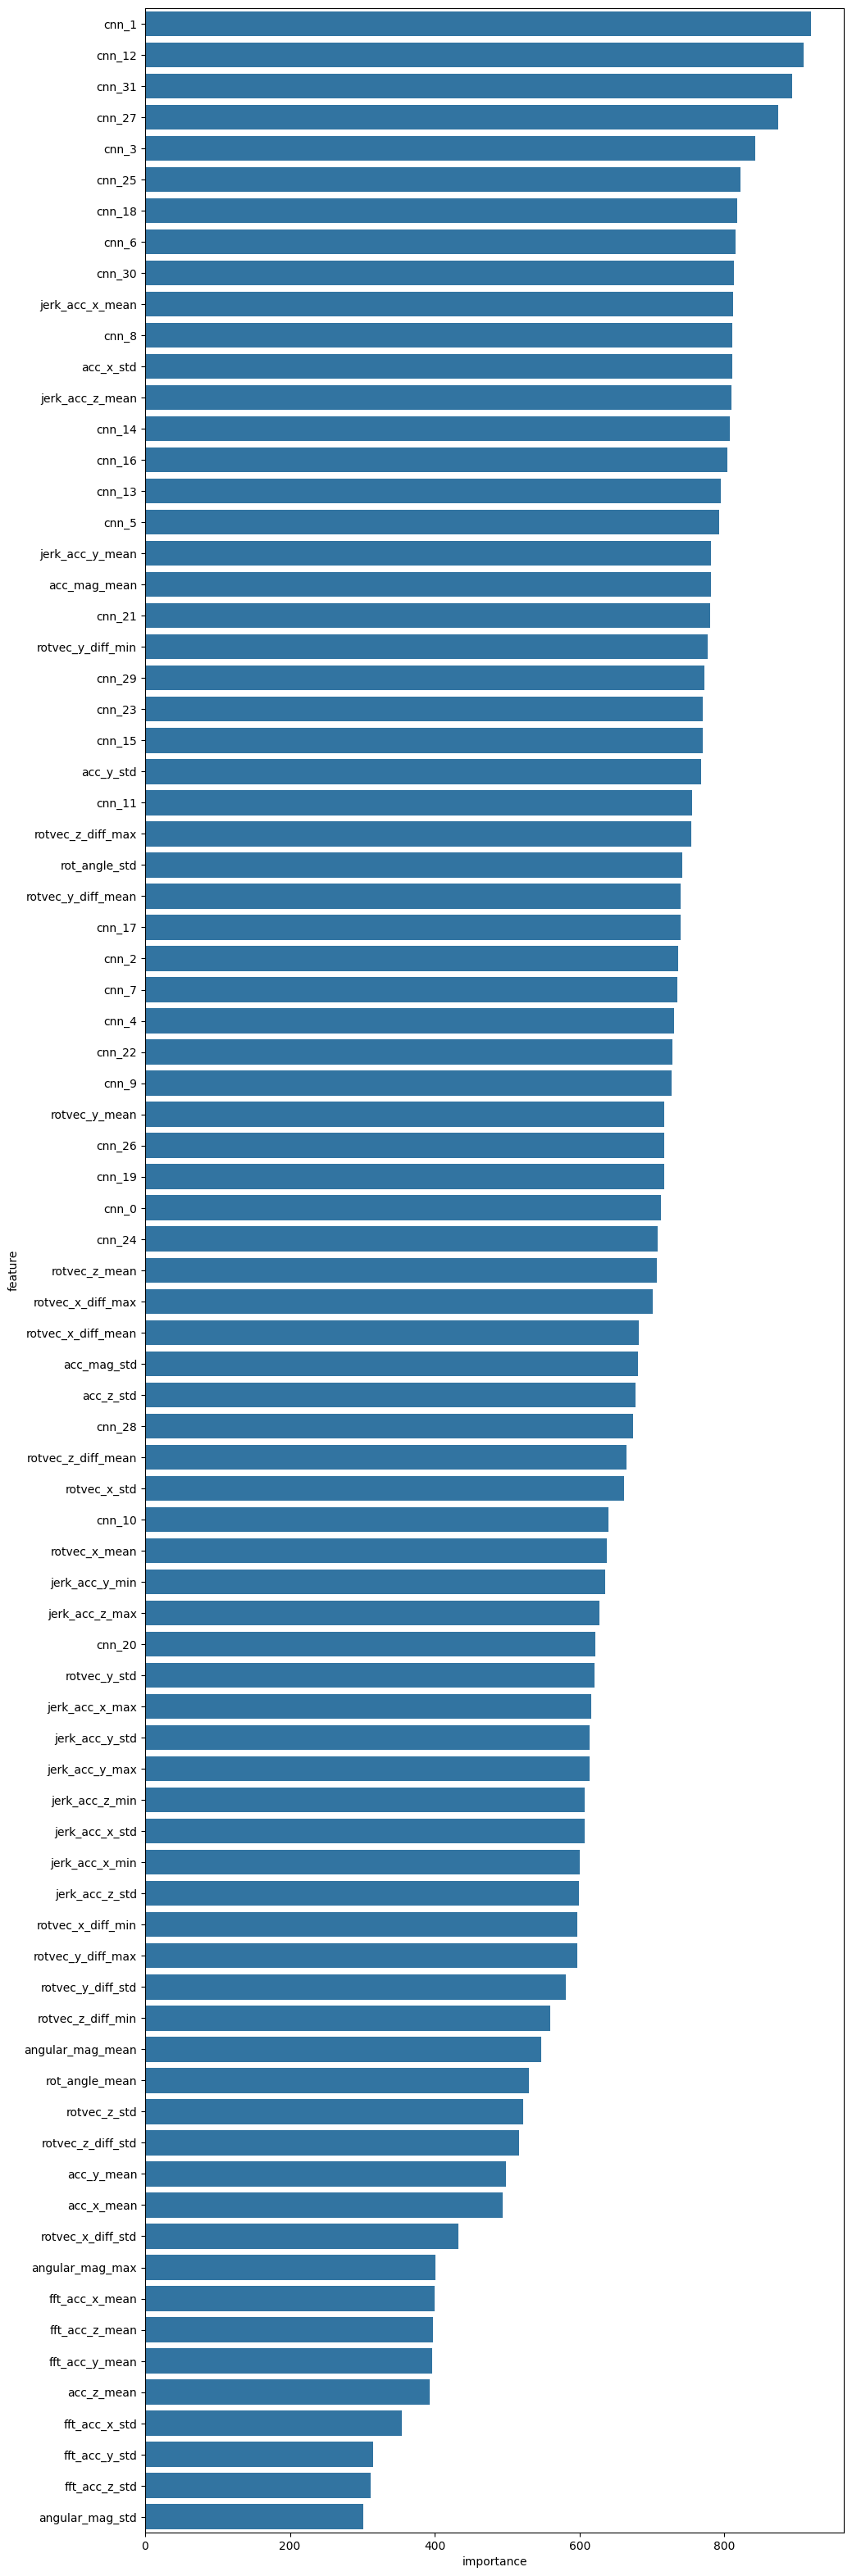

In [ ]:
avg_importances =np.mean(importances, axis=0)

statistical_feature_names = filtered_df.drop(columns=["gesture_first", "subject_first"]).columns.tolist()
cnn_feature_names = [f"cnn_{i}" for i in range(avg_importances.shape[0] - len(statistical_feature_names))]
col_names = statistical_feature_names + cnn_feature_names
print(col_names)

importance_df = pd.DataFrame({
    'feature': col_names,
    'importance': avg_importances,
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(11, 40))
sns.barplot(importance_df, x='importance', y='feature')
plt.title("")

importance_df[importance_df['feature'].str.contains("angular")]

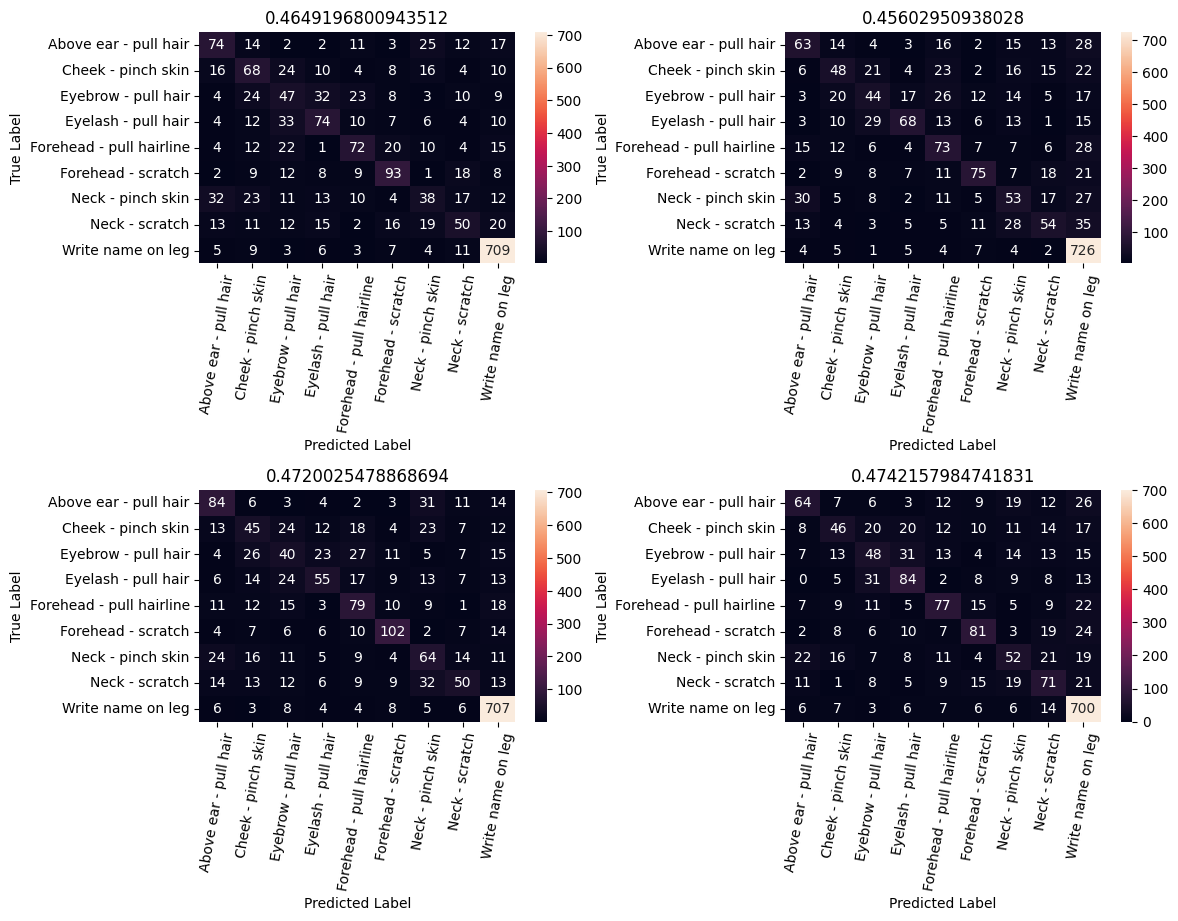

In [ ]:
plt.figure(figsize=(12, 12))
for i, fold in enumerate(lgbm_folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

([<matplotlib.axis.XTick at 0x74033cab0ef0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

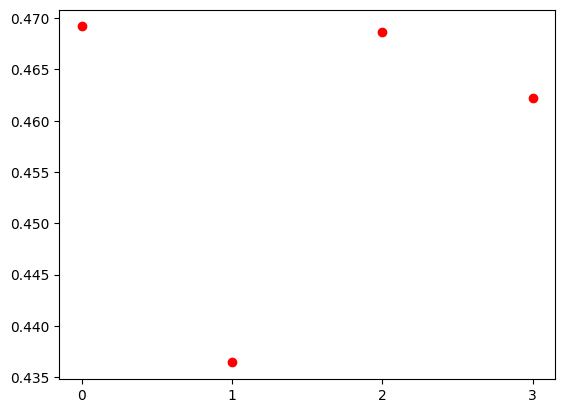

In [ ]:
macros = [f["f1_macro"] for f in lgbm_folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

# bad_idx = 2
# good_idx = 4

# print(f'good subjects: {test_subjects[good_idx]}')
# print(f'bad subjects: {test_subjects[bad_idx]}')

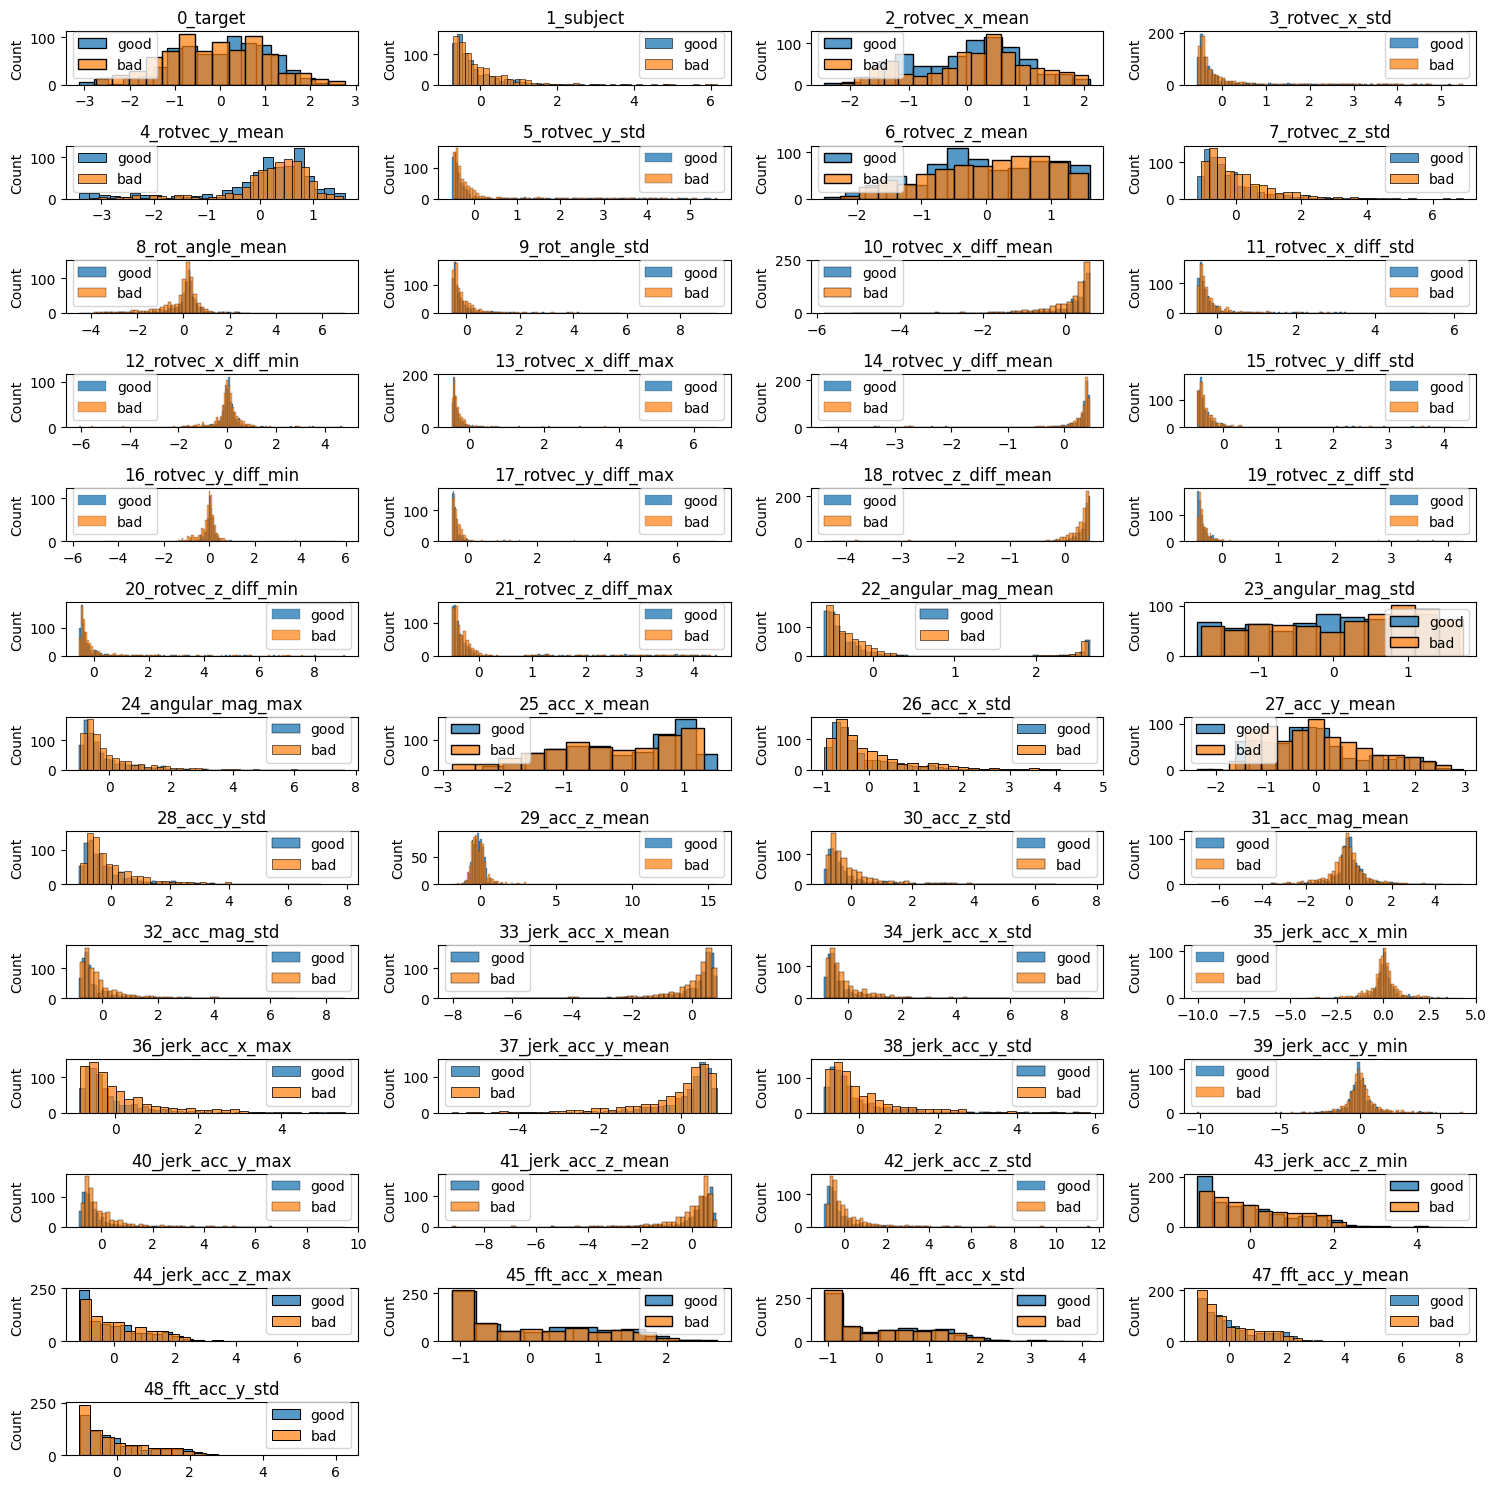

In [ ]:
# sub_df = pd.DataFrame(
#     {
#         "value": np.concat([data_good, data_bad]),
#         "fold": ["good"] * len(data_good) + ["bad"] * len(data_bad),
#     }
# )


graph_idx = 1
plt.figure(figsize=(15, 15))
for feature_idx in range(0, X_train_arr[0].shape[1]):
    data_good = X_test_arr[good_idx][:, feature_idx]
    data_bad = X_test_arr[bad_idx][:, feature_idx]

    plt.subplot(13, 4, graph_idx)
    plt.title(f"{feature_idx}_{filtered_df.columns[feature_idx]}")
    sns.histplot(data_good, label="good")
    sns.histplot(data_bad, alpha=0.7, label="bad")
    plt.legend()

    graph_idx += 1

plt.tight_layout()

<Axes: ylabel='Count'>

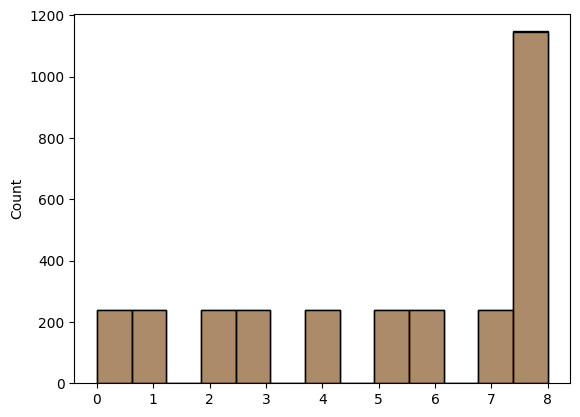

In [ ]:
sns.histplot(y_train_arr[good_idx])
sns.histplot(y_train_arr[bad_idx], alpha=0.5)

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
